# Sentinel-2 Resolution merging
This notebook demonstrated resolution merging in openEO, which is based on FORCE:
https://force-eo.readthedocs.io/en/latest/components/higher-level/l2i/index.html?highlight=resolution#level-2-improphe

The process is proposed for adoption, but not yet integrated into openEO:
https://github.com/Open-EO/openeo-processes/pull/221

This notebook uses false colour 'SWIR' images to demonstrate the process.
SWIR band B12 is only available in 20m for Sentinel-2, and is combined here with B8A (20m) and B04 (10m). 
Normally, this results in an image with only 20m resolution, but the use of resolution merge will (artificially) increase the resolution.

## Retrieve 20M SWIR

In [10]:
bbox = {"west": 5.08, "south": 51.22, "east": 5.10, "north": 51.23, "crs": "EPSG:4326"}
bands = ["B12", "B8A", "B04"]
dates = ("2021-03-06", "2021-03-07")

cube = connection.load_collection("TERRASCOPE_S2_TOC_V2", bands=bands)
cube = cube.filter_bbox(bbox=bbox)
cube = cube.filter_temporal(dates)

%time cube.download("./data/SWIR.nc", format="netCDF")

## Retrieve 10m SWIR

In [21]:
%time cube.resolution_merge(high_resolution_bands=['B04'], low_resolution_bands=['B12', 'B8A']).download("./data/SWIR_resmerge.nc", format="netCDF")

CPU times: user 7.14 ms, sys: 2.91 ms, total: 10.1 ms
Wall time: 3.35 s


## Retrieve 10m RGB

In [11]:
cube = connection.load_collection("TERRASCOPE_S2_TOC_V2", bands=["B04","B03","B02"])
cube = cube.filter_bbox(bbox=bbox)
cube = cube.filter_temporal(dates)

%time cube.download("./data/rgb.nc", format="netCDF")

CPU times: user 9.56 ms, sys: 1.4 ms, total: 11 ms
Wall time: 4.92 s


In [ ]:
## Load and plot all data 

In [3]:

swir = xr.open_dataset('./data/SWIR.nc',engine="h5netcdf")
swir

<xarray.Dataset>
Dimensions:      (t: 1, x: 137, y: 116)
Coordinates:
    spatial_ref  int64 ...
  * t            (t) datetime64[ns] 2021-03-06
  * x            (x) float64 6.453e+05 6.453e+05 ... 6.466e+05 6.466e+05
  * y            (y) float64 5.676e+06 5.676e+06 ... 5.677e+06 5.677e+06
Data variables:
    B04          (t, y, x) int16 ...
    B12          (t, y, x) int16 ...
    B8A          (t, y, x) int16 ...
Attributes:
    crs:           +proj=utm +zone=31 +datum=WGS84 +units=m +no_defs 
    grid_mapping:  spatial_ref
    nodata:        32767

In [4]:
swir_data = np.moveaxis(np.array([swir.B12.values[0],swir.B8A.values[0],swir.B04.values[0]]),0,2)/10000
p = np.percentile(swir_data, 97, axis=[0,1])
swir_data = swir_data / p[ None, None,:]

In [5]:
swir_hr = xr.open_dataset('./data/SWIR_resmerge.nc',engine="h5netcdf")
swir_data_hr = np.moveaxis(np.array([swir_hr.B12.values[0],swir_hr.B8A.values[0],swir_hr.B04.values[0]]),0,2)/10000
p = np.percentile(swir_data_hr, 97, axis=[0,1])
swir_data_hr = swir_data_hr / p[ None, None,:]

In [12]:
rgb = xr.open_dataset('./data/rgb.nc',engine="h5netcdf")
rgb_data = np.moveaxis(np.array([rgb.B04.values[0],rgb.B03.values[0],rgb.B02.values[0]]),0,2)/10000
p = np.percentile(rgb_data, 97, axis=[0,1])
rgb_data = rgb_data / p[ None, None,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'RGB_10M')

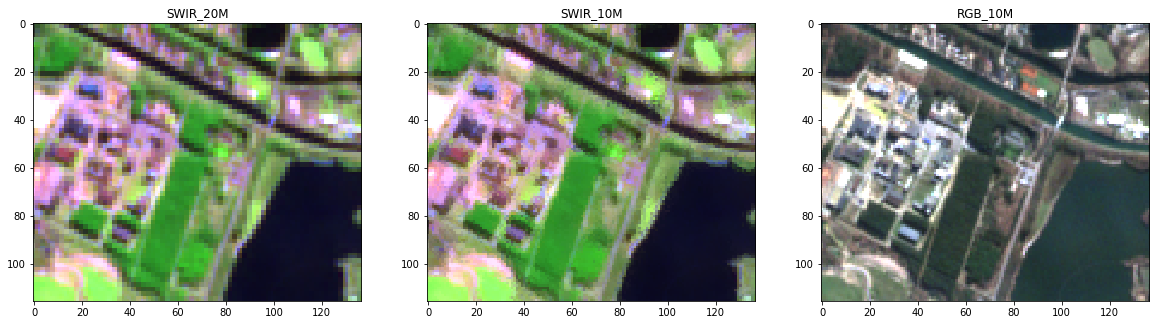

In [13]:

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,20))

ax1.imshow(swir_data,vmin=0,vmax=1)
ax1.set_title('SWIR_20M')

ax2.imshow(swir_data_hr,vmin=0,vmax=1)
ax2.set_title('SWIR_10M')

ax3.imshow(rgb_data,vmin=0,vmax=1)
ax3.set_title('RGB_10M')
